## Finding Stream/Tidal Tail

We start by showing spectroscopic data from SDSS and LAMOST. Then we move on to Gaia to use BHB and RRL to trace the stream.

**RA-dependent Proper motion selection**:\
Since the mock Boo III tidal stream showed a proper motion gradient along RA, we use this gradient as part of our data cuts. When we try to identify Boo III stream members using SDSS, LAMOST, and Gaia, we always do a proper motion cut that is dependent on that gradient.

We take our best fit curves (pmra vs. ra and pmdec vs. ra) from the stream model, and for each star from the dataset, we use its RA value to find an expected (pmra, pmdec). Then we use the errors and pm correlation of the star to make a covariance matrix ellipse, and check if the ellipse overlaps the expected pm (since these two things are all in the proper motion space). If they overlap then we select this star in our sample.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy import table, units
from scipy.optimize import curve_fit
import pickle

from galpy.orbit import Orbit
from galpy.util.conversion import get_physical
from galpy.potential import MWPotential2014, ChandrasekharDynamicalFrictionForce, HernquistPotential, \
                            MovingObjectPotential, evaluateRforces, evaluatephitorques, evaluatezforces, \
                            NonInertialFrameForce
from galpy.df import streamspraydf
from galpy.potential.mwpotentials import McMillan17

# Helper functions
from plot_functions import *
from analysis_functions_v2 import *

# params imported from plot_functions
plt.rcParams.update(params)

# Gaia EDR3 correction code
import gaia_edr3

A new version of galpy (1.9.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
# For citations on values, see notebook Part 1
pmra_label = r'$\mu_{\alpha}$cos($\delta$) [mas yr$^{-1}$]'
pmdec_label = r'$\mu_{\delta}$ [mas yr$^{-1}$]'

# Isochrone 
dartmouth_isochrone = ascii.read('boo3_iso.iso', header_start=8)
parsec_isochrone = ascii.read('parsec_isochrone.txt', header_start=13)
gr_iso_BHB, g_iso_BHB = get_BHB_iso_color_n_mag()

# Styx stream
styx_trace = ascii.read('styx.trace')

# Stellar locus (Figure 11 in Li et al. 2019 https://academic.oup.com/mnras/article/490/3/3508/5580642)
with fits.open('y3a2_empirical_stellar_locus_griz.fits') as hdu_list:
    stellar_locus = table.Table(hdu_list[1].data)

# 6D parameters
RA_BOO3 = 209.3     # deg  (from Grillmair 2009)
DEC_BOO3 = 26.8     # deg
DIST_BOO3 = 46.5    # kpc  (from Carlin 2018)
PMRA_BOO3 = -1.16   # mas yr^-1  (from Part 1 of this work)
PMDEC_BOO3 = -0.88  # mas yr^-1
VEL_BOO3 = 191.31   # km s^-1

# Uncertainties (no value for positions)
U_DIST_BOO3 = 2.0   
U_PMRA_BOO3 = 0.02  
U_PMDEC_BOO3 = 0.01 
U_VEL_BOO3 = 0.75

FEH_BOO3 = -2.31
U_FEH_BOO3 = 0.1

# From Part 1, our sample
boo3_table = ascii.read('boo3_S5_sample.dat')

These are some new custom columns, the other columns are original S5 data

Because astropy table stores Python boolean value as strings "True" and "False", it gets difficult when trying to use them as indices, so we are using 0 for false, 1 for true

In [3]:
boo3_table['ra_delta', 'dec_delta', 'dm', 'is_RRL', 'is_selected']

ra_delta,dec_delta,dm,is_RRL,is_selected
float64,float64,float64,int64,int64
0.9989419481245788,-0.3300811641929429,nan,0,1
1.7182765861049658,0.37783621963824576,nan,0,1
-1.6802123800266386,-0.306065539013923,nan,0,1
-0.8563761819284603,-0.5315075297169457,nan,0,1
-0.9741170273198592,-0.4915008016683752,nan,0,1
-0.9310128724501322,-0.19114326133602025,nan,0,1
0.16945211634448587,-0.7142251425710975,nan,0,1
0.22982415195768716,-0.3549406119640299,nan,0,1
0.20223978004409848,-0.24695265936856714,nan,0,1


### Loading the fiducial stream model from Part 2

In [4]:
with open("orbit_lead_fiducial.obj", "rb") as fileObj:
    orbit_leading = pickle.load(fileObj)
with open("orbit_trail_fiducial.obj", "rb") as fileObj:
    orbit_trailing = pickle.load(fileObj)

In [5]:
def get_model_curves(orbit_lead, orbit_trail, trim_range, get_pm_fit_params=False):
    ra = np.append(orbit_lead.ra(), orbit_trail.ra())
    dec = np.append(orbit_lead.dec(), orbit_trail.dec())
    pmra = np.append(orbit_lead.pmra(), orbit_trail.pmra())
    pmdec = np.append(orbit_lead.pmdec(), orbit_trail.pmdec())
    vlos = np.append(orbit_lead.vlos(), orbit_trail.vlos())
    dm = distance_to_dm(1000 * np.append(orbit_lead.dist(), orbit_trail.dist()))
    
    trim = (trim_range[0] < ra) & (ra < trim_range[1])
    
#     def poly_func(x, a, b, c, d):
#         y = a * x**3 + b * x**2 + c * x + d
#         return y

    def poly_func(x, a, b, c):
        y = a * x**2 + b * x + c
        return y

    p_opt_dec, _ = curve_fit(poly_func, ra[trim], dec[trim])
    p_opt_pmra, _ = curve_fit(poly_func, ra[trim], pmra[trim])
    p_opt_pmdec, _ = curve_fit(poly_func, ra[trim], pmdec[trim])
    p_opt_vlos, _ = curve_fit(poly_func, ra[trim], vlos[trim])
    p_opt_dm, _ = curve_fit(poly_func, ra[trim], dm[trim])

    x = np.arange(*trim_range, 0.1)

    # Make the model curves
    curve_pmra = np.array([x, poly_func(x, *p_opt_pmra)]).T
    curve_pmdec = np.array([x, poly_func(x, *p_opt_pmdec)]).T
    curve_rv = np.array([x, poly_func(x, *p_opt_vlos)]).T
    curve_dm = np.array([x, poly_func(x, *p_opt_dm)]).T
    curve_dec = np.array([x, poly_func(x, *p_opt_dec)]).T
    
    # This is just for convenience of the part below 
    # when we do the RA-dependent PM cut we need the pm model params
    if get_pm_fit_params:
        return [p_opt_pmra, p_opt_pmdec]
    
    return [curve_dec, curve_pmra, curve_pmdec, curve_rv, curve_dm]

In [6]:
orbit_curves_fiducial = get_model_curves(orbit_leading, orbit_trailing, [RA_BOO3-20, RA_BOO3+20])

In [7]:
def plot_five_params(ax, orbit_lead, orbit_trail, **kwargs):
    """Specifically for plotting the stream parameters.
    <ax> should contain 5 axes.
    Just making code shorter.
    """
    ax[0].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.dec(), orbit_trail.dec()), **kwargs)
    ax[1].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.pmra(), orbit_trail.pmra()), **kwargs)
    ax[2].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.pmdec(), orbit_trail.pmdec()), **kwargs)
    ax[3].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), np.append(orbit_lead.vlos(), orbit_trail.vlos()), **kwargs)
    ax[4].scatter(np.append(orbit_lead.ra(), orbit_trail.ra()), distance_to_dm(1000 * np.append(orbit_lead.dist(), orbit_trail.dist())), **kwargs)

def plot_five_curves(ax, orbit_curves, **kwargs):
    """Specifically for plotting the stream parameters.
    <ax> should contain 5 axes.
    Just making code shorter.
    """
    ax0_kwargs = kwargs.copy()
    ax0_kwargs.pop('label', None)
    
    ax[0].plot(orbit_curves[0][:,0], orbit_curves[0][:,1], **ax0_kwargs)
    ax[1].plot(orbit_curves[1][:,0], orbit_curves[1][:,1], **kwargs)
    ax[2].plot(orbit_curves[2][:,0], orbit_curves[2][:,1], **kwargs)
    ax[3].plot(orbit_curves[3][:,0], orbit_curves[3][:,1], **kwargs)
    ax[4].plot(orbit_curves[4][:,0], orbit_curves[4][:,1], **kwargs)

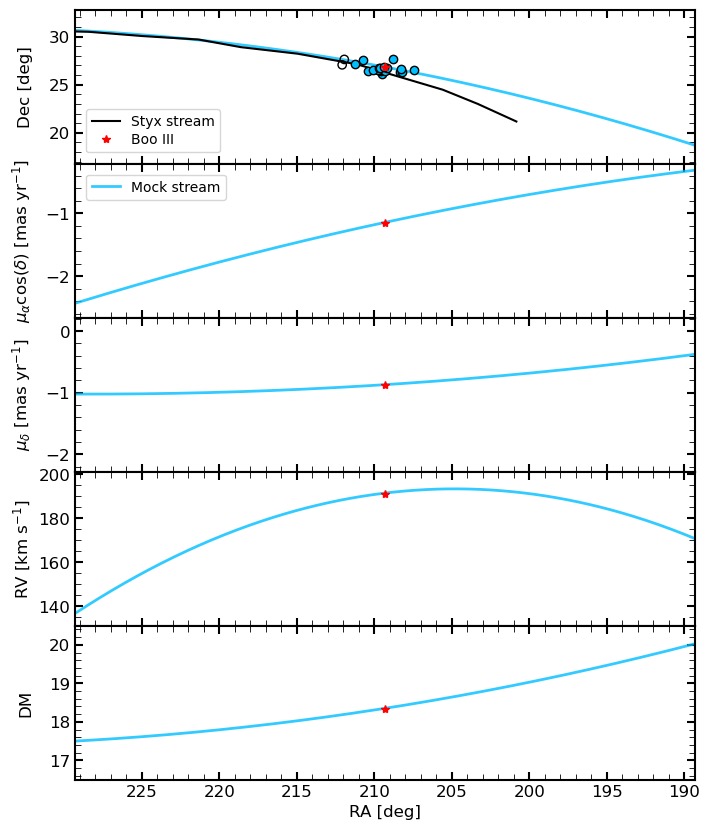

In [8]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

plot_five_curves(ax, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)

ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
# This one is the blue circles in the members plot from Part 1
plot_onsky(fig, ax[0], 
           boo3_table[boo3_table['is_selected'].astype(bool) & np.invert(boo3_table['is_RRL'].astype(bool))], 
           '', marker='o', c='deepskyblue', ec='k', zorder=2)
# This one is the open circles in the members plot (the ones outside 3 r_half)
plot_onsky(fig, ax[0], 
           boo3_table[np.invert(boo3_table['is_selected'].astype(bool))], 
           '', marker='o', c='none', ec='k', zorder=2)

for ax_i, label, value, scale in zip(ax, ["Dec [deg]", pmra_label, pmdec_label, r"RV [km s$^{-1}$]", "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-10, DEC_BOO3+6), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (VEL_BOO3-60, VEL_BOO3+10), (16.5, 20.5)]):
    ax_i.plot(RA_BOO3, value, "*r")
    ax_i.set_ylabel(label, fontsize=12)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
ax[4].set_xlabel("RA [deg]", fontsize=12)

fig.align_ylabels(ax)
ax[0].legend(loc='lower left', fontsize=10)
ax[1].legend(loc='upper left', fontsize=10)#, bbox_to_anchor=(1.5, 0), fontsize=12)
plt.show()

Here we load data from the other catalogues:\
SDSS (10 deg radius from Boo III centre)\
LAMOST (10 deg)\
Gaia (20 deg)\
DECaLS (20 deg)

We want to find spectroscopic members in SDSS and LAMOST, but they don't have proper motion so we pair them with Gaia proper motion.

In [13]:
print("Loading SDSS")
with fits.open('sdss_dr14_10deg.fits') as hdu_list:
    table_sdss = table.Table(hdu_list[1].data)
print("Loading LAMOST")
with fits.open('lamost_dr8_lrs_10deg.fits') as hdu_list:
    table_lamost_lrs = table.Table(hdu_list[1].data)
with fits.open('lamost_dr8_mrs_10deg.fits') as hdu_list:
    table_lamost_mrs = table.Table(hdu_list[1].data)
    
print("Loading Gaia RRL")
with fits.open('gaia_rrl_dr3_all.fits') as hdu_list:
    _table_rrl1 = table.Table(hdu_list[1].data)
with fits.open('GaiaDR3_RRLs_withMu_Lite.fits') as hdu_list:
    _table_rrl2 = table.Table(hdu_list[1].data)
table_rrl = table.join(_table_rrl1, _table_rrl2['source_id', 'EBV_SFD'], keys=['source_id'])

print("Loading DECaLS")
with fits.open('ls_dr9_20deg_box.fits') as hdu_list: #'ls_dr9_over10deg_position_and_mag.fits'
    table_ls = table.Table(hdu_list[1].data)
    
print("Loading Gaia data...")
print("Progress: 0/4", end='\r')
with fits.open('gaia_dr3_20deg_part1.fits') as hdu_list:
    _table_gaia1 = table.Table(hdu_list[1].data)
print("Progress: 1/4", end='\r')
with fits.open('gaia_dr3_20deg_part2.fits') as hdu_list:
    _table_gaia2 = table.Table(hdu_list[1].data)
print("Progress: 2/4", end='\r')
with fits.open('gaia_dr3_20deg_part3.fits') as hdu_list:
    _table_gaia3 = table.Table(hdu_list[1].data)
print("Progress: 3/4", end='\r')
with fits.open('gaia_dr3_20deg_part4.fits') as hdu_list:
    _table_gaia4 = table.Table(hdu_list[1].data)
print("Progress: 4/4")
print("Combining...")
table_gaia_full = table.vstack([_table_gaia1, _table_gaia2, _table_gaia3, _table_gaia4])
print("Complete")

Loading SDSS
Loading LAMOST
Loading Gaia RRL
Loading DECaLS
Loading Gaia data...
Progress: 4/4
Combining...
Complete


In [10]:
p_opt_pmra, p_opt_pmdec = get_model_curves(orbit_leading, orbit_trailing, [RA_BOO3-20, RA_BOO3+20], 
                                           get_pm_fit_params=True)

In [16]:
def pm_cut_with_gradient(table_data, pmra_curve_params, pmdec_curve_params, pad=0):
    """Return an astropy table with selected stars from <table_data>, taking into
    account proper motion gradients along both RA and Dec directions. Each gradient is
    described by a polynomial curve, where <pmra_curve_params> and <pmdec_curve_params>
    contain the coefficients for the polynomial curves.
    
    The selection procedure is the following:
    - Take a star in <table_data>, use its pmra_error, pmdec_error, and pmra_pmdec_corr
    to create a covariance matrix. Then use the matrix to find semi-major and semi-minor 
    axes of the covariance matrix ellipse, and use shapelyPolygon to create the ellipse.
    - Take this star's RA coordinate, combined with coefficients given in <pmra_curve_params>
    and <pmdec_curve_params>, and input these into the quadratic function poly_2deg, from
    which we will obtain a pair of (pmra, pmdec) coordinates. This is the predicted location
    of this star in the proper motion space.
    - If the ellipse contains this predicted point, add it to the table of selected stars.
    Otherwise, move to the next star in <table_data>.
    
    Parameters
    ----------
    table_data: 
        An astropy table containing information about stars
    pad: 
        A value to increase the ellipse size. Added in quadrature with the PM errors on
        each star.
    pmra_curve_params: 
        polynomial coefficients for the function poly_2deg, 
        for the model curve in PMRA vs. RA
    pmdec_curve_params:
        polynomial coefficients for the function poly_2deg, 
        for the model curve in PMDEC vs. RA
    
    Precondition
    ------------
    table_data should include the following column names: 
    pmra, pmdec, pmra_error, pmdec_error, pmra_pmdec_corr
    
    Return
    ------
    A new astropy table with selected members.
    """    
    selected_stars = table.Table()
    selected_stars.columns = table_data.columns
    selected_stars.remove_rows(slice(0, len(selected_stars), 1))
    
    # For parametrizing the ellipse later
    t = np.arange(0, 2*np.pi, 0.01)

    for i in range(len(table_data)):
        #--- CREATE ELLIPSE ---#
        
        # adding the pad to pm error
        pmra_sigma_i = np.sqrt(table_data['pmra_error'][i]**2 + pad**2) 
        pmdec_sigma_i = np.sqrt(table_data['pmdec_error'][i]**2 + pad**2)
        
        # covariance matrix entries
        var_x = pmra_sigma_i**2
        var_y = pmdec_sigma_i**2
        cov_xy = table_data['pmra_pmdec_corr'][i] * pmra_sigma_i * pmdec_sigma_i

        # Creating the matrix for better understanding
        cov_matrix = np.array([[var_x, cov_xy], 
                               [cov_xy, var_y]])
        a = cov_matrix[0, 0]
        c = cov_matrix[1, 1]
        b = cov_matrix[0, 1]

        # The sqrt of the lambdas are the semi-major and semi-minor axes
        lambda1 = (a+c)/2 + np.sqrt(((a-c)/2)**2 + b**2)
        lambda2 = (a+c)/2 - np.sqrt(((a-c)/2)**2 + b**2)

        if b == 0 and a >= c:
            theta = 0
        elif b == 0 and a < c:
            theta = np.pi/2
        else:
            theta = np.arctan2(lambda1 - a, b)

        x_t = np.zeros(len(t) + 1)
        y_t = np.zeros(len(t) + 1)
        x_t[:-1] = lambda1**0.5 * np.cos(theta) * np.cos(t) - lambda2**0.5 * np.sin(theta) * np.sin(t) + table_data['pmra'][i]
        y_t[:-1] = lambda1**0.5 * np.sin(theta) * np.cos(t) + lambda2**0.5 * np.cos(theta) * np.sin(t) + table_data['pmdec'][i]
        # Make a closed shape to create a polygon
        x_t[-1] = x_t[0]
        y_t[-1] = y_t[0]

        ellipse = shapelyPolygon(np.array([x_t, y_t]).T)
        
        #--- EXPECTED PM CENTER FROM RA ---#
        pmra_expected = poly_2deg(table_data['ra'][i], *pmra_curve_params)
        pmdec_expected = poly_2deg(table_data['ra'][i], *pmdec_curve_params)

        pm_center = shapelyPoint(pmra_expected, pmdec_expected)
        
        #--- CHECKING FOR SELECTION ---#
        if ellipse.contains(pm_center):
            selected_stars.add_row(table_data[i])
    
    return selected_stars

## SDSS

In [14]:
print("Sample size:", len(table_sdss))

# Add DECaLS magnitudes to SDSS
ls_matched_to_sdss, sep2d = crossmatch(table_sdss, table_ls, sep_dist=0.5, get_sep2d=True)

table_sdss = table.hstack([table_sdss[sep2d < 0.5*units.arcsec], ls_matched_to_sdss['dered_mag_g'], 
                               ls_matched_to_sdss['dered_mag_r'], ls_matched_to_sdss['dered_mag_z']])

print("After adding magnitude:", len(table_sdss))

# Add Gaia proper motion to SDSS
gaia_matched_to_sdss, sep2d = crossmatch(table_sdss, table_gaia_full, sep_dist=0.5, get_sep2d=True)

table_sdss = table.hstack([table_sdss[sep2d < 0.5*units.arcsec], 
                            gaia_matched_to_sdss['pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'pmra_pmdec_corr']])

print("After adding proper motion:", len(table_sdss))

# Take out the rows with no [Fe/H] measurement
table_sdss = table_sdss[table_sdss['fehadopunc'] > -9999]

print("After removing rows without [Fe/H] value:", len(table_sdss))

Sample size: 48381
After adding magnitude: 43837
After adding proper motion: 14016
After removing rows without [Fe/H] value: 6864


In [17]:
# RA-dependent PM cut
table_sdss_pm = pm_cut_with_gradient(table_sdss, p_opt_pmra, p_opt_pmdec, pad=0.5)
print("PM cut sample:", len(table_sdss_pm))

table_sdss_pm = table_sdss_pm[(120 < table_sdss_pm['elodiervfinal']) & (table_sdss_pm['elodiervfinal'] < 240)]
print("After removing velocities too far away:", len(table_sdss_pm))

PM cut sample: 77
After removing velocities too far away: 11


In [39]:
def plot_four_panels(ax, data, headers, label, color):
    """
    headers: [ra, dec, pmra, pmdec, pmra_err, pmdec_err, g_mag, r_mag, rv, feh, rv_err, feh_err]
    """
    ax[0].scatter(data[headers[0]], data[headers[1]], c=color, label=label, marker='o', s=70, ec='k', zorder=2)
    ax[1].errorbar(data[headers[2]], data[headers[3]], xerr=data[headers[4]], yerr=data[headers[5]], c=color, label=label, fmt='o', ms=8, mec='k', capsize=0, lw=1)
    ax[2].scatter(data[headers[6]] - data[headers[7]], data[headers[7]], c=color, label=label, marker='o', s=70, ec='k', zorder=2)
    ax[3].errorbar(data[headers[9]], data[headers[8]], xerr=data[headers[11]], yerr=data[headers[10]], c=color, label=label, fmt='o', ms=8, mec='k', lw=1)
    
def plot_four_panels_on_stream(ax, data, headers, label, color, marker='o', size=20):
    """
    Parameter list is messy because scatter and errorbar don't have the same keyword arguments.
    
    headers: [ra, dec, pmra, pmdec, pmra_err, pmdec_err, rv, rv_err]
    """
    ax[0].scatter(data[headers[0]], data[headers[1]], c=color, marker=marker, s=size, ec='k', zorder=2)#  label=label,
    ax[1].errorbar(data[headers[0]], data[headers[2]], yerr=data[headers[4]], c=color, label=label, fmt=marker, mec='k', ms=size, capsize=0, lw=1)
    ax[2].errorbar(data[headers[0]], data[headers[3]], yerr=data[headers[5]], c=color, label=label, fmt=marker, mec='k', ms=size, capsize=0, lw=1)
    ax[3].errorbar(data[headers[0]], data[headers[6]], yerr=data[headers[7]], c=color, label=label, fmt=marker, mec='k', ms=size, capsize=0, lw=1)

In [19]:
_, _sep2d = crossmatch(table_sdss_pm, table_rrl, get_sep2d=True)
_sdss_rrl = table_sdss_pm[_sep2d < 1*units.arcsec]

## LAMOST

Velocity offset correction from [Liu et al. 2018](https://iopscience.iop.org/article/10.3847/1538-4357/aacf91) LAMOST and APOGEE

In [20]:
table_lamost_lrs['rv_corrected'] = table_lamost_lrs['rv'] + 7.328
table_lamost_mrs['rv_corrected'] = table_lamost_mrs['rv_lasp1'] + 7.328

In [21]:
print("Sample size:", len(table_lamost_lrs), "and", len(table_lamost_mrs))

ls_matched_to_lamostlrs, sep2d = crossmatch(table_lamost_lrs, table_ls, sep_dist=0.5, get_sep2d=True)
table_lamost_lrs = table.hstack([table_lamost_lrs[sep2d < 0.5*units.arcsec], ls_matched_to_lamostlrs['dered_mag_g'], 
                                 ls_matched_to_lamostlrs['dered_mag_r'], ls_matched_to_lamostlrs['dered_mag_z']])

ls_matched_to_lamostmrs, sep2d = crossmatch(table_lamost_mrs, table_ls, sep_dist=0.5, get_sep2d=True)
table_lamost_mrs = table.hstack([table_lamost_mrs[sep2d < 0.5*units.arcsec], ls_matched_to_lamostmrs['dered_mag_g'], 
                                 ls_matched_to_lamostmrs['dered_mag_r'], ls_matched_to_lamostmrs['dered_mag_z']])

print("Assigned magnitudes:", len(table_lamost_lrs), "and", len(table_lamost_mrs))

# Add Gaia proper motion, this time we match by the Gaia source id directly
table_lamost_lrs['source_id'] = np.int64(table_lamost_lrs['gaia_source_id'])
table_lamost_lrs = table.join(table_lamost_lrs, table_gaia_full['source_id', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'pmra_pmdec_corr'], keys=['source_id'])
table_lamost_mrs['source_id'] = np.int64(table_lamost_mrs['gaia_source_id'])
table_lamost_mrs = table.join(table_lamost_mrs, table_gaia_full['source_id', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'pmra_pmdec_corr'], keys=['source_id'])

print("Assigned proper motions:", len(table_lamost_lrs), "and", len(table_lamost_mrs))

Sample size: 99148 and 15687
Assigned magnitudes: 88287 and 14938
Assigned proper motions: 86795 and 14787


In [22]:
table_lamost_lrs_pm = pm_cut_with_gradient(table_lamost_lrs, p_opt_pmra, p_opt_pmdec, pad=0.5)
table_lamost_mrs_pm = pm_cut_with_gradient(table_lamost_mrs, p_opt_pmra, p_opt_pmdec, pad=0.5)
print("PM cut:", len(table_lamost_lrs_pm), "and", len(table_lamost_mrs_pm))

table_lamost_lrs_pm = table_lamost_lrs_pm[(120 < table_lamost_lrs_pm['rv_corrected']) & (table_lamost_lrs_pm['rv_corrected'] < 240)]
table_lamost_mrs_pm = table_lamost_mrs_pm[(120 < table_lamost_mrs_pm['rv_corrected']) & (table_lamost_mrs_pm['rv_corrected'] < 240)]
print("Again, RV cut (120 to 240):", len(table_lamost_lrs_pm), "and", len(table_lamost_mrs_pm))

PM cut: 164 and 18
Again, RV cut (120 to 240): 8 and 0


In [41]:
_member = boo3_table[boo3_table['is_selected'].astype(bool) & np.invert(boo3_table['is_RRL'].astype(bool))]
_non_member = boo3_table[np.invert(boo3_table['is_selected'].astype(bool))]

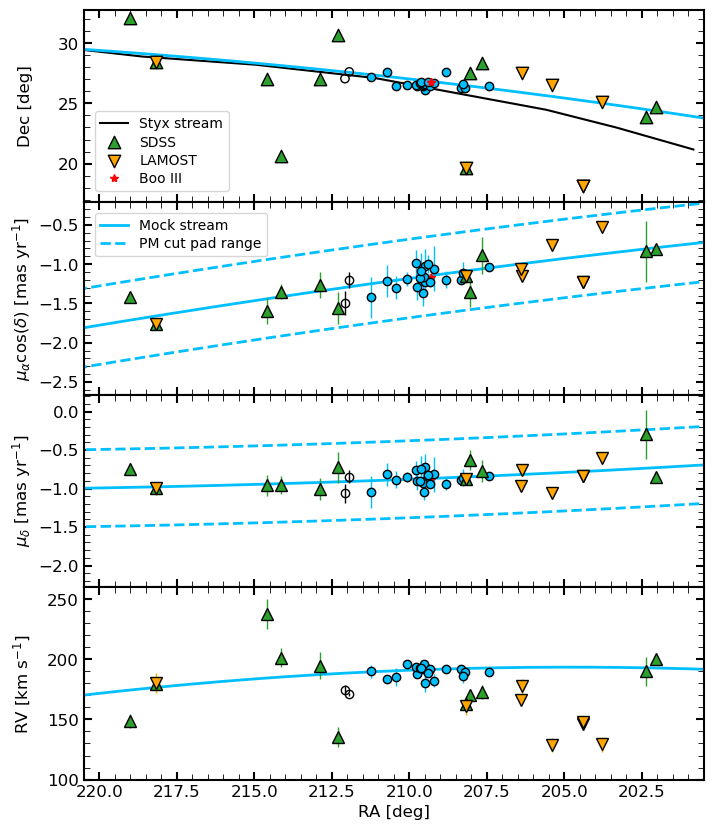

In [72]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
ax[0].plot(orbit_curves_fiducial[0][:,0], orbit_curves_fiducial[0][:,1], c='deepskyblue', lw=2)
ax[0].scatter(_member['ra'], _member['dec'], c='deepskyblue', marker='o', ec='k', zorder=2)
ax[0].scatter(_non_member['ra'], _non_member['dec'], c='none', marker='o', ec='k', zorder=2)
ax[0].scatter(table_sdss_pm['ra'], table_sdss_pm['dec'], c='tab:green', marker='^', s=80, ec='k', zorder=2, label='SDSS')
ax[0].scatter(table_lamost_lrs_pm['ra'], table_lamost_lrs_pm['dec'], c='orange', marker='v', s=80, ec='k', zorder=2, label='LAMOST')
ax[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
ax[0].legend(loc='lower left', fontsize=10)

ax[1].plot(orbit_curves_fiducial[1][:,0], orbit_curves_fiducial[1][:,1], c='deepskyblue', lw=2, label='Mock stream')
ax[1].plot(orbit_curves_fiducial[1][:,0], orbit_curves_fiducial[1][:,1] + 0.5, c='deepskyblue', ls='--', lw=2, label='PM cut pad range')
ax[1].plot(orbit_curves_fiducial[1][:,0], orbit_curves_fiducial[1][:,1] - 0.5, c='deepskyblue', ls='--', lw=2)
ax[1].errorbar(_member['ra'], _member['pmra'], yerr=_member['pmra_error'], c='deepskyblue', fmt='o', mec='k', capsize=0, lw=1)
ax[1].errorbar(_non_member['ra'], _non_member['pmra'], yerr=_non_member['pmra_error'], c='none', fmt='o', mec='k', ecolor='k', capsize=0, lw=1)
ax[1].errorbar(table_sdss_pm['ra'], table_sdss_pm['pmra'], yerr=table_sdss_pm['pmra_error'], c='tab:green', fmt='^', mec='k', ms=8, capsize=0, lw=1)
ax[1].errorbar(table_lamost_lrs_pm['ra'], table_lamost_lrs_pm['pmra'], yerr=table_lamost_lrs_pm['pmra_error'], c='orange', fmt='v', mec='k', ms=8, capsize=0, lw=1)
ax[1].legend(loc='upper left', fontsize=10)

ax[2].plot(orbit_curves_fiducial[2][:,0], orbit_curves_fiducial[2][:,1], c='deepskyblue', lw=2)
ax[2].plot(orbit_curves_fiducial[2][:,0], orbit_curves_fiducial[2][:,1] + 0.5, c='deepskyblue', ls='--', lw=2)
ax[2].plot(orbit_curves_fiducial[2][:,0], orbit_curves_fiducial[2][:,1] - 0.5, c='deepskyblue', ls='--', lw=2)
ax[2].errorbar(_member['ra'], _member['pmdec'], yerr=_member['pmdec_error'], c='deepskyblue', fmt='o', mec='k', capsize=0, lw=1)
ax[2].errorbar(_non_member['ra'], _non_member['pmdec'], yerr=_non_member['pmdec_error'], c='none', fmt='o', mec='k', ecolor='k', capsize=0, lw=1)
ax[2].errorbar(table_sdss_pm['ra'], table_sdss_pm['pmdec'], yerr=table_sdss_pm['pmdec_error'], c='tab:green', fmt='^', mec='k', ms=8, capsize=0, lw=1)
ax[2].errorbar(table_lamost_lrs_pm['ra'], table_lamost_lrs_pm['pmdec'], yerr=table_lamost_lrs_pm['pmdec_error'], c='orange', fmt='v', mec='k', ms=8, capsize=0, lw=1)

ax[3].plot(orbit_curves_fiducial[3][:,0], orbit_curves_fiducial[3][:,1], c='deepskyblue', lw=2)
ax[3].errorbar(_member['ra'], _member['vel_calib'], yerr=_member['vel_calib_std'], c='deepskyblue', fmt='o', mec='k', capsize=0, lw=1)
ax[3].errorbar(_non_member['ra'], _non_member['vel_calib'], yerr=_non_member['vel_calib_std'], c='none', fmt='o', mec='k', ecolor='k', capsize=0, lw=1)
ax[3].errorbar(table_sdss_pm['ra'], table_sdss_pm['elodiervfinal'], yerr=table_sdss_pm['elodiervfinalerr'], c='tab:green', fmt='^', mec='k', ms=8, capsize=0, lw=1)
ax[3].errorbar(table_lamost_lrs_pm['ra'], table_lamost_lrs_pm['rv_corrected'], yerr=table_lamost_lrs_pm['rv_err'], c='orange', fmt='v', mec='k', ms=8, capsize=0, lw=1)
ax[3].set_xlabel("RA [deg]", fontsize=12)

for ax_i, label, value, scale in zip(ax, ["Dec [deg]", pmra_label, pmdec_label, r"RV [km s$^{-1}$]"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3],
                                     [(DEC_BOO3-10, DEC_BOO3+6), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (100, 260)]):
    ax_i.plot(RA_BOO3, value, "*r")
    ax_i.set_ylabel(label, fontsize=12)
    ax_i.set_xlim(200.5, 220.5)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()

fig.align_ylabels(ax)
fig.savefig('sdss_lamost.pdf', dpi=300)
plt.show()

**Note**: In the second last panel (RV), the point closest to the model curve also appears in the SDSS sample, so this is redundant.

## Gaia
The result from SDSS and LAMOST is inconclusive. So now we try BHB and RRL stars in Gaia DR3.

---
SKIP THE NEXT THREE CELLS.

This part is how we obtain and save the data.

---

In [116]:
print("Within square box (40 deg in side length):", len(table_gaia_full))

table_gaia_full = angular_radius_cut(table_gaia_full, [RA_BOO3, DEC_BOO3], 20)
print("Within 20 deg radius:", len(table_gaia_full))

ls_matched_to_gaia, sep2d = crossmatch(table_gaia_full, table_ls, sep_dist=0.5, get_sep2d=True)
table_gaia_full = table.hstack([table_gaia_full[sep2d < 0.5*units.arcsec], ls_matched_to_gaia['dered_mag_g'], 
                               ls_matched_to_gaia['dered_mag_r'], ls_matched_to_gaia['dered_mag_z']])
print("Assigned magnitudes:", len(table_gaia_full))

Within square box (40 deg in side length): 4044422
Within 20 deg radius: 3373253
Assigned magnitudes: 3059092


In [117]:
table_gaia_pm_cut = pm_cut_with_gradient(table_gaia_full, p_opt_pmra, p_opt_pmdec, pad=0.5)
print("PM cut:", len(table_gaia_pm_cut))

PM cut: 51630


In [118]:
# ascii.write(table_gaia_pm_cut, 'table_gaia_pm_cut_20.dat', overwrite=True)

---
BEGIN HERE.

This part reads the saved data and continues the analysis.

---

In [68]:
table_gaia_pm_cut = ascii.read('table_gaia_pm_cut_20.dat')
print('All data from the PM cut:', len(table_gaia_pm_cut))

boo3_gaia_blue = table_gaia_pm_cut[table_gaia_pm_cut['dered_mag_g'] - table_gaia_pm_cut['dered_mag_r'] < 0]
print('Take blue stars, g-r < 0. Remaining:', len(boo3_gaia_blue))

All data from the PM cut: 51630
Take blue stars, g-r < 0. Remaining: 1879


In [78]:
boo3_gaia_BHB, polygon1, polygon2 = cmd_cut_BHB(boo3_gaia_blue, 'dered_mag_g', 'dered_mag_r', 
                                                gr_iso_BHB, g_iso_BHB+distance_to_dm(DIST_BOO3*1000), 
                                                0.1, 2, get_polygon=True)

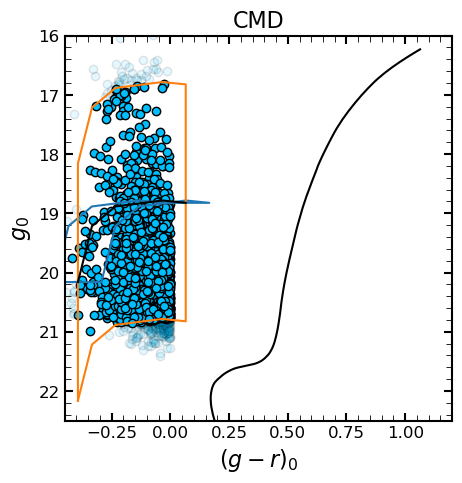

In [79]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(*polygon1.exterior.xy)
ax.plot(*polygon2.exterior.xy)
plot_RGB_isochrone(ax, dartmouth_isochrone['DECam_g'], dartmouth_isochrone['DECam_r'], distance_to_dm(DIST_BOO3*1000), '[Fe/H] = -2.1', c='k', zorder=1)
plot_BHB_isochrone(ax, distance_to_dm(DIST_BOO3*1000), c='k')
plot_cmd(fig, ax, boo3_gaia_blue['dered_mag_g'], boo3_gaia_blue['dered_mag_r'], '', c='deepskyblue', ec='k', alpha=0.1)
plot_cmd(fig, ax, boo3_gaia_BHB['dered_mag_g'], boo3_gaia_BHB['dered_mag_r'], '', c='deepskyblue', ec='k')
ax_labels(ax, r'$(g-r)_0$', r'$g_0$', 'CMD')
ax.set_xlim(-0.45, 1.2)
ax.set_ylim(16, 22.5)
ax.invert_yaxis()

In [80]:
append_BHB_dm(boo3_gaia_BHB, 'dered_mag_g', 'dered_mag_r')

These samples don't have RV so we'll just remove the RV vs. RA panel.

In [81]:
def trim_along_curve(data, curve, lower_shift, upper_shift):
    indices1 = data['dec'] < np.interp(data['ra'], curve[:,0], curve[:,1]+upper_shift)
    indices2 = data['dec'] > np.interp(data['ra'], curve[:,0], curve[:,1]+lower_shift)
    
    return data[indices1 & indices2]

In [82]:
boo3_gaia_BHB_cut1 = trim_along_curve(boo3_gaia_BHB, orbit_curves_fiducial[0], -5, 5)
boo3_gaia_BHB_cut2 = trim_along_curve(boo3_gaia_BHB, orbit_curves_fiducial[0], 10, 15)
boo3_gaia_BHB_cut3 = trim_along_curve(boo3_gaia_BHB, orbit_curves_fiducial[0], -15, -10)

In [94]:
def plot_four_curves(ax, orbit_curves, **kwargs):
    ax[1].plot(orbit_curves[1][:,0], orbit_curves[1][:,1], **kwargs)
    ax[2].plot(orbit_curves[2][:,0], orbit_curves[2][:,1], **kwargs)
    ax[3].plot(orbit_curves[4][:,0], orbit_curves[4][:,1], **kwargs)
    kwargs.pop('label', None)
    ax[0].plot(orbit_curves[0][:,0], orbit_curves[0][:,1], **kwargs)
    
def plot_four_curves_with_offset(ax, orbit_curves, offset, **kwargs):
    ax[1].plot(orbit_curves[1][:,0] + offset, orbit_curves[1][:,1] + offset, **kwargs)
    ax[1].plot(orbit_curves[1][:,0] - offset, orbit_curves[1][:,1] - offset, **kwargs)
    kwargs.pop('label', None)
    ax[2].plot(orbit_curves[2][:,0] + offset, orbit_curves[2][:,1] + offset, **kwargs)
    ax[2].plot(orbit_curves[2][:,0] - offset, orbit_curves[2][:,1] - offset, **kwargs)

def plot_gaia_data(ax, data, color, label):
    ax[0].scatter(data['ra'], data['dec'], c=color, label=label, marker='.', zorder=2, alpha=0.8)
    ax[2].errorbar(data['ra'], data['pmdec'], yerr=data['pmdec_error'], c=color, label=label, fmt='.', capsize=0, lw=1, alpha=0.8)
    ax[1].errorbar(data['ra'], data['pmra'], yerr=data['pmra_error'], c=color, label=label, fmt='.', capsize=0, lw=1, alpha=0.8)
    ax[3].scatter(data['ra'], data['dm'], c=color, label=label, marker='.', zorder=2, alpha=0.8)

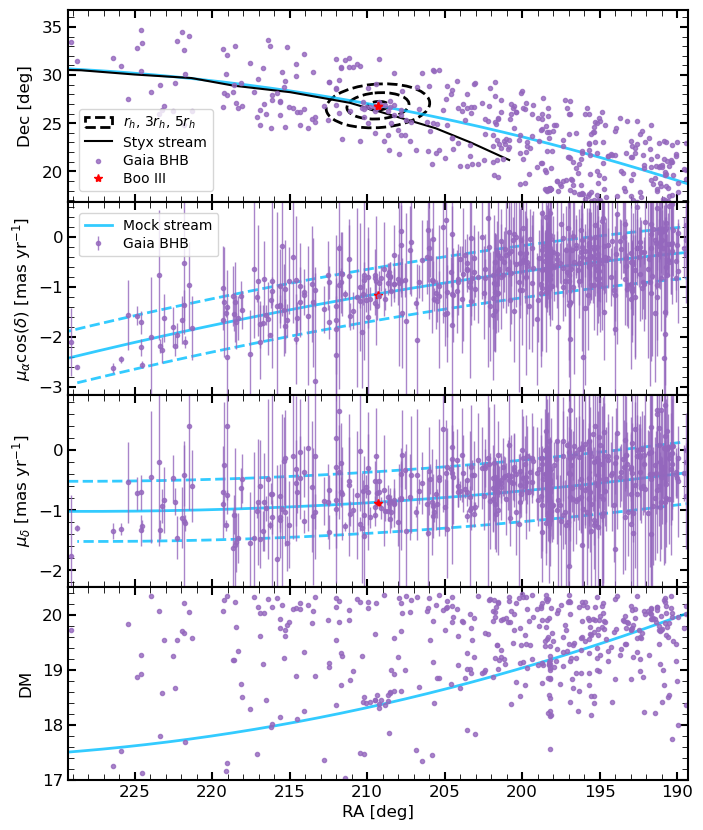

In [95]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

plot_four_curves(ax, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)
plot_four_curves_with_offset(ax, orbit_curves_fiducial, offset=0.5, c="deepskyblue", ls='--', alpha=0.8, lw=2)

plot_rh(ax[0])
ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
plot_gaia_data(ax, boo3_gaia_BHB_cut1, 'tab:purple', 'Gaia BHB')

for ax_i, label, value, scale in zip(ax, ["Dec [deg]", pmra_label, pmdec_label, "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-10, DEC_BOO3+10), (PMRA_BOO3-2.0, PMRA_BOO3+1.85), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.8), (17, 20.5)]):
    ax_i.plot(RA_BOO3, value, "*r")
    ax_i.set_ylabel(label, fontsize=12)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
ax[3].set_xlabel("RA [deg]", fontsize=12)

fig.align_ylabels(ax)
ax[0].legend(loc='lower left', fontsize=10)
ax[1].legend(loc='upper left', fontsize=10)#, bbox_to_anchor=(1.5, 0), fontsize=12)
plt.show()

## RRL

In [100]:
print("Gaia DR3 RRL catalogue:", len(table_rrl))

table_rrl = angular_radius_cut(table_rrl, [RA_BOO3, DEC_BOO3], 20)
print("Radius cut 20 deg:", len(table_rrl))

ls_matched_to_rrl, sep2d = crossmatch(table_rrl, table_ls, sep_dist=0.5, get_sep2d=True)
table_rrl = table.hstack([table_rrl[sep2d < 0.5*units.arcsec], ls_matched_to_rrl['dered_mag_g'], 
                               ls_matched_to_rrl['dered_mag_r'], ls_matched_to_rrl['dered_mag_z']])
print("Assigning magnitudes:", len(table_rrl))

table_rrl = table_rrl[np.isfinite(table_rrl['pmra']) & np.isfinite(table_rrl['pmdec'])]
print("Remove nan and inf values in PM:", len(table_rrl))

Gaia DR3 RRL catalogue: 2072
Radius cut 20 deg: 2072
Assigning magnitudes: 2072
Remove nan and inf values in PM: 2072


In [101]:
table_rrl_cut = pm_cut_with_gradient(table_rrl, p_opt_pmra, p_opt_pmdec, pad=0.5)
print("PM cut:", len(table_rrl_cut))

add_dm_to_RRLs(table_rrl_cut, FEH_BOO3)

boo3_gaia_RRL = table.setdiff(table_rrl_cut, boo3_table[boo3_table['is_RRL'].astype(bool)], keys=['source_id'])
print("Removing repeats from S5 base sample:", len(boo3_gaia_RRL))

PM cut: 279
Removing repeats from S5 base sample: 276


In [102]:
boo3_gaia_RRL_cut1 = trim_along_curve(boo3_gaia_RRL, orbit_curves_fiducial[0], -5, 5)
boo3_gaia_RRL_cut2 = trim_along_curve(boo3_gaia_RRL, orbit_curves_fiducial[0], 5, 15)
boo3_gaia_RRL_cut3 = trim_along_curve(boo3_gaia_RRL, orbit_curves_fiducial[0], -15, -5)

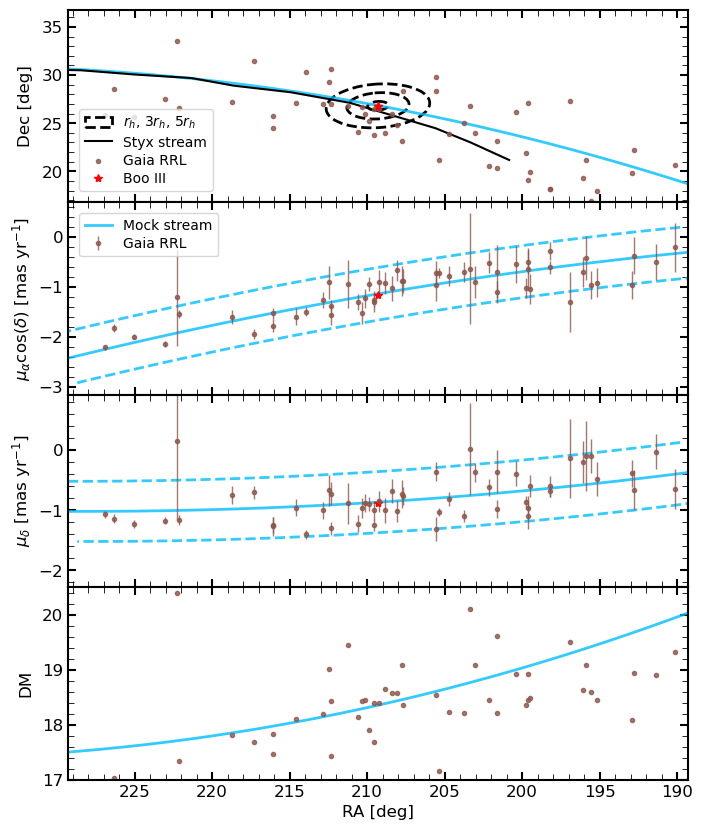

In [104]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

plot_four_curves(ax, orbit_curves_fiducial, c="deepskyblue", label="Mock stream", alpha=0.8, lw=2)
plot_four_curves_with_offset(ax, orbit_curves_fiducial, offset=0.5, c="deepskyblue", ls='--', alpha=0.8, lw=2)

plot_rh(ax[0])
ax[0].plot(styx_trace['col1'], styx_trace['col2'], 'k', label='Styx stream')
plot_gaia_data(ax, boo3_gaia_RRL_cut1, 'tab:brown', 'Gaia RRL')

for ax_i, label, value, scale in zip(ax, ["Dec [deg]", pmra_label, pmdec_label, "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-10, DEC_BOO3+10), (PMRA_BOO3-2.0, PMRA_BOO3+1.85), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.8), (17, 20.5)]):
    ax_i.plot(RA_BOO3, value, "*r")
    ax_i.set_ylabel(label, fontsize=12)
    ax_i.set_xlim(RA_BOO3-20, RA_BOO3+20)
    ax_i.set_ylim(*scale)
    ax_i.invert_xaxis()
ax[0].plot(RA_BOO3, DEC_BOO3, "*r", label='Boo III')
ax[3].set_xlabel("RA [deg]", fontsize=12)

fig.align_ylabels(ax)
ax[0].legend(loc='lower left', fontsize=10)
ax[1].legend(loc='upper left', fontsize=10)#, bbox_to_anchor=(1.5, 0), fontsize=12)
plt.show()

We were considering the galstreams data for Sgr, but they don't have velocities. This is just kept here for display.
```python
import galstreams

mws = galstreams.MWStreams(verbose=False, implement_Off=False)
sgr_curve = mws['Sagittarius-A20'].track

def plot_sgr_curve(ax):
    ax[0].plot(sgr_curve.ra.deg, sgr_curve.dec.deg, '.', c='orange', ms=6)
    ax[1].plot(sgr_curve.ra.deg, sgr_curve.pm_ra_cosdec, '.', c='orange', label='Sgr stream', ms=6)
    ax[2].plot(sgr_curve.ra.deg, sgr_curve.pm_dec, '.', c='orange', ms=6)
    ax[3].plot(sgr_curve.ra.deg, sgr_curve.radial_velocity, '.', c='orange', ms=6)
    ax[4].plot(sgr_curve.ra.deg, distance_to_dm(sgr_curve.distance.value * 1000), '.', c='orange', ms=6)
```

What we are using is the data from (Vasiliev et al. 2020)[https://arxiv.org/abs/2009.10726]

In [105]:
sgr_data = ascii.read('catalogue.txt')
# remove nan values
sgr_with_vlos = sgr_data[np.invert(np.isnan(sgr_data['vlos']))]

In [106]:
def plot_sgr_data(ax):
    ax[0].plot(sgr_data['ra'], sgr_data['dec'], '.', c='orange', label='Vasiliev et al. 2020', alpha=0.8, zorder=1)
    ax[1].plot(sgr_data['ra'], sgr_data['pmra'], '.', c='orange', alpha=0.8, zorder=1)
    ax[2].plot(sgr_data['ra'], sgr_data['pmdec'], '.', c='orange', alpha=0.8, zorder=1)
    ax[3].plot(sgr_data['ra'], sgr_data['vlos'], '.', c='orange', alpha=0.8, zorder=1)
    ax[4].plot(sgr_data['ra'], distance_to_dm(sgr_data['dist'] * 1000), '.', c='orange', alpha=0.8, zorder=1)
    
def plot_model_data(ax, lead, trail, **kwargs):
    ax[0].scatter(np.append(lead.ra(), trail.ra()), np.append(lead.dec(), trail.dec()), marker='.', alpha=0.8, label='Mock stream', **kwargs)
    ax[1].scatter(np.append(lead.ra(), trail.ra()), np.append(lead.pmra(), trail.pmra()), marker='.', alpha=0.8, **kwargs)
    ax[2].scatter(np.append(lead.ra(), trail.ra()), np.append(lead.pmdec(), trail.pmdec()), marker='.', alpha=0.8, **kwargs)
    ax[3].scatter(np.append(lead.ra(), trail.ra()), np.append(lead.vlos(), trail.vlos()), marker='.', alpha=0.8, **kwargs)
    ax[4].scatter(np.append(lead.ra(), trail.ra()), distance_to_dm(1000 * np.append(lead.dist(), trail.dist())), marker='.', alpha=0.8, **kwargs)

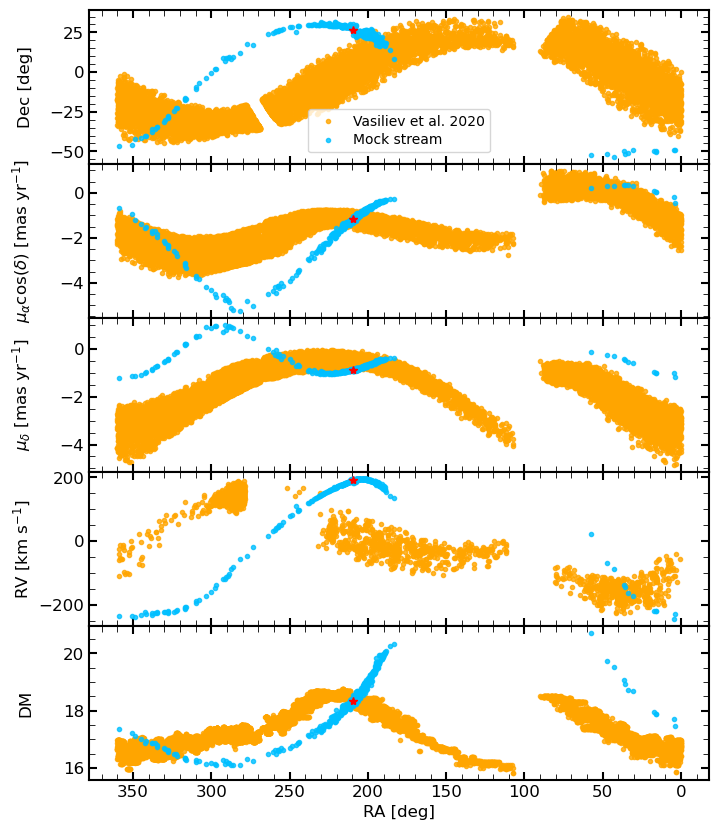

In [107]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 10))
fig.subplots_adjust(hspace=0)

plot_sgr_data(ax)
plot_model_data(ax, orbit_leading, orbit_trailing, c='deepskyblue', zorder=2)

for ax_i, label, value, scale in zip(ax, ["Dec [deg]", pmra_label, pmdec_label, r"RV [km s$^{-1}$]", "DM"], 
                                     [DEC_BOO3, PMRA_BOO3, PMDEC_BOO3, VEL_BOO3, distance_to_dm(DIST_BOO3*1000)],
                                     [(DEC_BOO3-30, DEC_BOO3+30), (PMRA_BOO3-1.5, PMRA_BOO3+0.95), 
                                      (PMDEC_BOO3-1.4, PMDEC_BOO3+1.1), (VEL_BOO3-100, VEL_BOO3+50), (16.5, 20.5)]):
    ax_i.plot(RA_BOO3, value, "*r")
    ax_i.set_ylabel(label, fontsize=12)
    ax_i.invert_xaxis()
ax[4].set_xlabel("RA [deg]", fontsize=12)
ax[0].legend(loc='lower center', fontsize=10)
fig.align_ylabels(ax)
plt.show()